<a href="https://colab.research.google.com/github/huiningjiao02-ship-it/Huining-JIAO/blob/main/Binary_Classification_Prediction_Project_on_Heart_Disease_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [ ]:
# 1. 导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 让图更清晰
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

In [ ]:
# 1. 读取 UCI Heart Disease 数据集(id = 45)
#    符合“从 UCI repository 选数据集”的要求
# ============================================
heart = fetch_ucirepo(id=45)

In [ ]:
# 读取特征 X 和标签 y（num: 0~4）
X = heart.data.features
y = heart.data.targets

print("Features shape:", X.shape)
print("Targets shape:", y.shape)

# -----------------------------
# 查看前几行特征
# -----------------------------
print("\nFirst few rows of features:")
display(X.head())

# -----------------------------
# 查看原始 num 标签分布
# 0 = healthy, 1-4 = different degrees of disease
# -----------------------------
print("\nLabel distribution of original 'num' (0=healthy, 1-4=disease):")
print(y["num"].value_counts())



Features shape: (303, 13)
Targets shape: (303, 1)

First few rows of features:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0



Label distribution of original 'num' (0=healthy, 1-4=disease):
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64


In [ ]:
3.# ============================================
# 2. 目标变量处理：把 num 转成二分类 target
#    0 = 没有心脏病；1 = 有心脏病
# ============================================
y_binary = (y["num"] > 0).astype(int)
y_binary.name = "target"

print("\n二分类后的标签分布（0=无病, 1=有病）：")
print(y_binary.value_counts())



二分类后的标签分布（0=无病, 1=有病）：
target
0    164
1    139
Name: count, dtype: int64


In [ ]:
# 把 X 和 y_binary 拼在一起，方便同时丢掉有 NaN 的行
data_all = pd.concat([X, y_binary], axis=1)
print("\n含 NaN 的樣本數:", data_all.isna().any(axis=1).sum())

# 丢掉包含 NaN 的行
data_all_clean = data_all.dropna()

# 拆回 X、y
X_clean = data_all_clean.drop(columns=["target"])
y_clean = data_all_clean["target"]

print("After dropping NaN:")
print("X_clean shape:", X_clean.shape)
print("y_clean shape:", y_clean.shape)


含 NaN 的樣本數: 6
After dropping NaN:
X_clean shape: (297, 13)
y_clean shape: (297,)


In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_clean
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


[Simple Perceptron] Accuracy: 0.7000
              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.62      0.89      0.74        28

    accuracy                           0.70        60
   macro avg       0.74      0.71      0.69        60
weighted avg       0.74      0.70      0.69        60



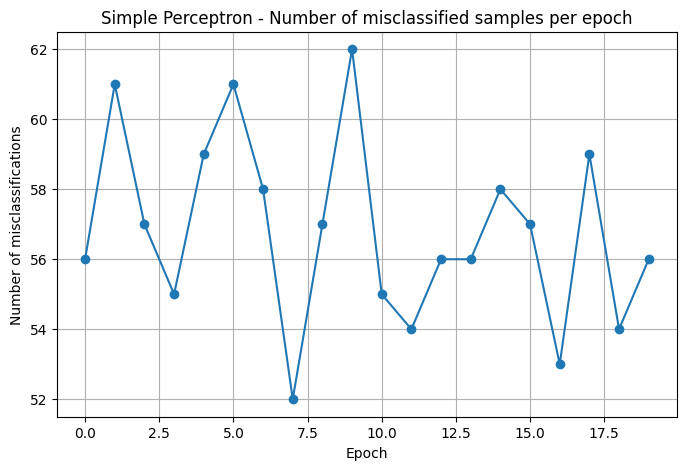

In [ ]:
# From-scratch 感知机（简单实现，帮助理解）
#    这部分可以在 report 里解释为“我们自己
#    实现了一个简单的感知机学习规则”
# ============================================
class SimplePerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs

    def fit(self, X, y):
        # y: 0/1 → -1/+1
        y_bin = np.where(y == 0, -1, 1)
        n_samples, n_features = X.shape

        self.w = np.zeros(n_features)
        self.b = 0.0

        self.errors_per_epoch_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, yi in zip(X, y_bin):
                linear_output = np.dot(xi, self.w) + self.b
                y_hat = 1 if linear_output >= 0 else -1
                if y_hat != yi:
                    # 感知机更新规则
                    self.w += self.lr * yi * xi
                    self.b += self.lr * yi
                    errors += 1
            self.errors_per_epoch_.append(errors)

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        y_hat = np.where(linear_output >= 0, 1, -1)
        # 转回 0/1
        return np.where(y_hat == -1, 0, 1)


# 训练 from-scratch 感知机（使用标准化后的特征）
simple_perc = SimplePerceptron(lr=0.01, epochs=20)
simple_perc.fit(X_train_scaled, y_train.values)
y_pred_simple = simple_perc.predict(X_test_scaled)

acc_simple = accuracy_score(y_test, y_pred_simple)
print("\n[Simple Perceptron] Accuracy: {:.4f}".format(acc_simple))
print(classification_report(y_test, y_pred_simple))

# 画一下每个 epoch 的错误数（可放 PPT）
plt.figure()
plt.plot(simple_perc.errors_per_epoch_, marker="o")
plt.title("Simple Perceptron - Number of misclassified samples per epoch")
plt.xlabel("Epoch")
plt.ylabel("Number of misclassifications")
plt.show()

In [ ]:
#5. 使用 sklearn 的 Perceptron（主模型之一）
# ============================================
sk_perc = Perceptron(
    max_iter=1000,
    eta0=0.01,
    random_state=RANDOM_STATE
)
sk_perc.fit(X_train_scaled, y_train)
y_pred_perc = sk_perc.predict(X_test_scaled)

acc_perc = accuracy_score(y_test, y_pred_perc)
print("\n[Sklearn Perceptron] Accuracy: {:.4f}".format(acc_perc))
print(classification_report(y_test, y_pred_perc))



[Sklearn Perceptron] Accuracy: 0.7833
              precision    recall  f1-score   support

           0       0.85      0.72      0.78        32
           1       0.73      0.86      0.79        28

    accuracy                           0.78        60
   macro avg       0.79      0.79      0.78        60
weighted avg       0.79      0.78      0.78        60



In [ ]:
#6. 其它模型：Logistic Regression
#    老师要求“Models being tested on the dataset”
# ============================================
# Logistic Regression (作為 baseline 對比模型)
log_reg = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
print("\n[Logistic Regression] Accuracy: {:.4f}".format(acc_lr))
print(classification_report(y_test, y_pred_lr))




[Logistic Regression] Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60




Model comparison:


,Model,Accuracy
2,Logistic Regression,0.833333
1,Perceptron (sklearn),0.783333
0,Simple Perceptron (from scratch),0.700000


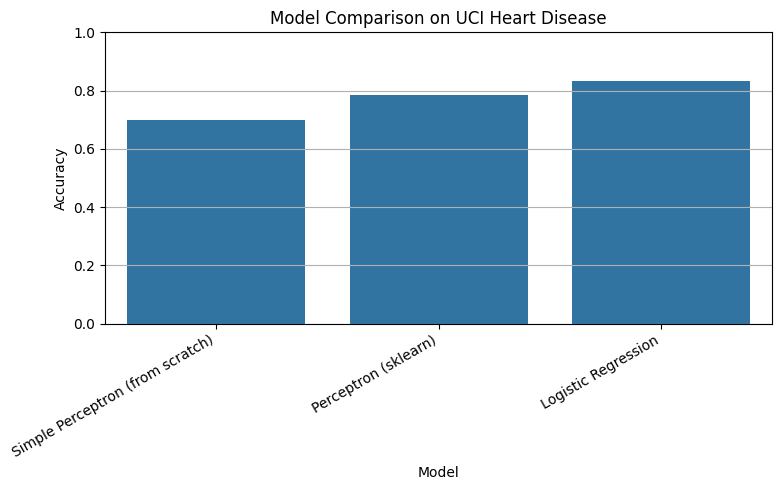

In [ ]:
# 9. 把三個模型結果放到一個表裡 (方便做 PPT)
results = pd.DataFrame({
    "Model": [
        "Simple Perceptron (from scratch)",
        "Perceptron (sklearn)",
        "Logistic Regression"
    ],
    "Accuracy": [
        acc_simple,
        acc_perc,
        acc_lr
    ]
})

print("\nModel comparison:")
display(results.sort_values(by="Accuracy", ascending=False))

plt.figure()
sns.barplot(data=results, x="Model", y="Accuracy")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1.0)
plt.title("Model Comparison on UCI Heart Disease")
plt.tight_layout()
plt.show()



Best model: Logistic Regression


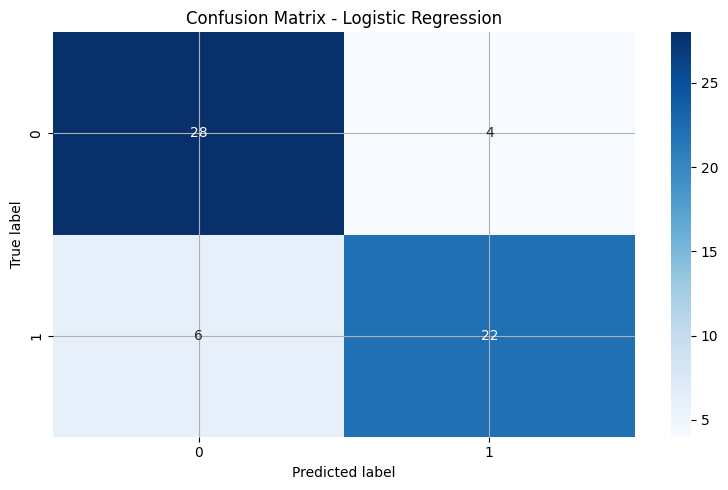

In [ ]:
# 10. 自动选择最佳模型并画混淆矩阵

# 从 results 表里找出 Accuracy 最高的那一行
best_row = results.sort_values(by="Accuracy", ascending=False).iloc[0]
best_model_name = best_row["Model"]
print(f"\nBest model: {best_model_name}")

# 根据最佳模型名字，选对应的预测结果
if "Simple Perceptron" in best_model_name:
    best_pred = y_pred_simple
elif "Perceptron (sklearn)" in best_model_name:
    best_pred = y_pred_perc
else:  # 剩下的就是 Logistic Regression
    best_pred = y_pred_lr

# 计算混淆矩阵
cm = confusion_matrix(y_test, best_pred)

# 画混淆矩阵
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()
